<a href="https://colab.research.google.com/github/Ajinthan1998/disease_level/blob/main/disease_level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!date

Wed Jan 17 12:49:33 PM UTC 2024


In [ ]:
!git clone https://github.com/Ajinthan1998/disease_level

fatal: destination path 'disease_level' already exists and is not an empty directory.


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from google.colab import drive #connect to google drive
drive.mount('/content/gdrive')
from sklearn.model_selection import train_test_split

Mounted at /content/gdrive


In [ ]:
IMAGE_SIZE = 512
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/My Drive/Melanoma_Level",
    shuffle = True, #randomly shuffle and load them
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 627 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Medium', 'Normal', 'Sever']

In [ ]:
len(dataset)

20

In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy)

(32, 512, 512, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 2, 2, 0, 2, 0, 2, 0, 2, 1, 1, 2, 1, 2, 1, 0, 1, 1, 2, 2, 0,
       1, 0, 1, 2, 2, 2, 1, 0, 0, 0], dtype=int32)>>


In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch[0])

tf.Tensor(
[[[157. 108.  94.]
  [157. 108.  94.]
  [164. 116. 104.]
  ...
  [179. 131. 111.]
  [170. 123. 103.]
  [174. 127. 107.]]

 [[157. 108.  94.]
  [159. 110.  96.]
  [163. 115. 103.]
  ...
  [178. 130. 110.]
  [173. 126. 106.]
  [174. 127. 107.]]

 [[158. 109.  95.]
  [161. 112.  98.]
  [161. 111. 100.]
  ...
  [178. 129. 112.]
  [177. 130. 112.]
  [175. 128. 110.]]

 ...

 [[154. 107.  81.]
  [154. 107.  81.]
  [155. 108.  82.]
  ...
  [189. 146. 130.]
  [191. 145. 130.]
  [186. 140. 125.]]

 [[161. 114.  86.]
  [162. 115.  87.]
  [158. 111.  83.]
  ...
  [190. 147. 131.]
  [193. 147. 132.]
  [187. 141. 126.]]

 [[153. 106.  78.]
  [158. 111.  83.]
  [155. 108.  80.]
  ...
  [188. 145. 129.]
  [194. 148. 133.]
  [189. 143. 128.]]], shape=(512, 512, 3), dtype=float32)


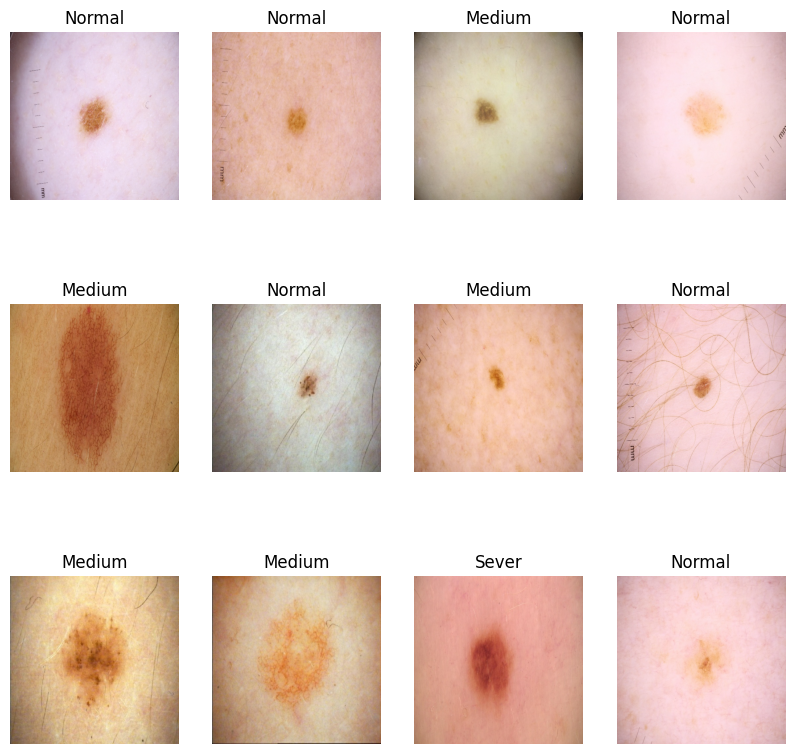

In [ ]:
plt.figure(figsize=(10,10)) #set image size
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1) #show all (12) the images
    plt.imshow(image_batch[i].numpy().astype("uint8")) #because of it float so using '.astype("uint8")' to covert to int.
    plt.title(class_names[label_batch[i]]) #show it's labes name
    plt.axis("off") #not showing axis
    #80% ==> training , 20% ==> 10% validation, 10% test

validatation used during training process, once we done each epochs then we do 10% test dataset

In [ ]:
train_size = 0.8
len(dataset)*train_size

16.0

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

20

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [ ]:
#validation size is 10% so 0.1
val_size = 0.1
#actual val dataset size
len(dataset)*val_size

2.0

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

0

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [ ]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size) #skip size to val size
  test_ds = ds.skip(train_size).take(val_size)

  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

16

In [ ]:
len(test_ds)

2

In [ ]:
len(val_ds)

2

In [ ]:
#cache ,read the images from disk then keep that in the memory
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255) #if we have datas with size of 255 but predicted datas also conert to size=255.
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), #just created preprocessing some layers.
    layers.experimental.preprocessing.RandomRotation(0.2), #using augmentation to 1 image to increase more images Ex 1 to 5.
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(n_classes, activation='softmax'), #normalize the probability of the clzes
])

model.build(input_shape=input_shape) #just an API

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 512, 512, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 512, 512, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 510, 510, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 255, 255, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 253, 253, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 126, 126, 64)        0         
 g2D)                                                 

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #define loss Fn
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1, #print just lot of outs
    validation_data = val_ds #each epochs help to track the accuracy
)

Epoch 1/10
16/16 [==============================] - 7s 238ms/step - loss: 1.0953 - accuracy: 0.3687 - val_loss: 0.9911 - val_accuracy: 0.5312
Epoch 2/10
16/16 [==============================] - 4s 221ms/step - loss: 0.8712 - accuracy: 0.5772 - val_loss: 0.7121 - val_accuracy: 0.6875
Epoch 3/10
16/16 [==============================] - 4s 224ms/step - loss: 0.7128 - accuracy: 0.6493 - val_loss: 0.5675 - val_accuracy: 0.7031
Epoch 4/10
16/16 [==============================] - 4s 223ms/step - loss: 0.6837 - accuracy: 0.6954 - val_loss: 0.7716 - val_accuracy: 0.5625
Epoch 5/10
16/16 [==============================] - 4s 221ms/step - loss: 0.7031 - accuracy: 0.6954 - val_loss: 0.5331 - val_accuracy: 0.7812
Epoch 6/10
16/16 [==============================] - 4s 222ms/step - loss: 0.5679 - accuracy: 0.7335 - val_loss: 0.6453 - val_accuracy: 0.6406
Epoch 7/10
16/16 [==============================] - 4s 232ms/step - loss: 0.5609 - accuracy: 0.7455 - val_loss: 0.6666 - val_accuracy: 0.7812
Epoch 

In [ ]:
scores = model.evaluate(test_ds)
scores

2/2 [==============================] - 0s 108ms/step - loss: 0.3778 - accuracy: 0.8750


[0.3777981102466583, 0.875]

In [ ]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

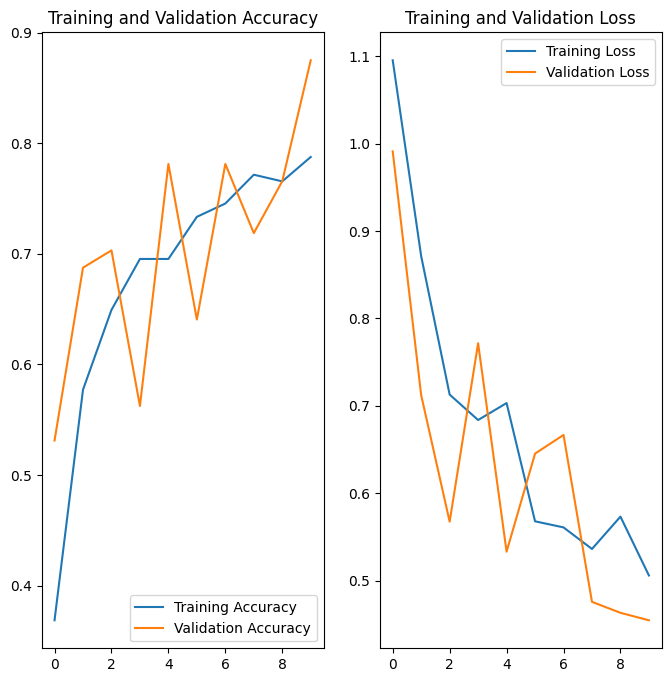

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
first image's actual label: Medium
1/1 [==============================] - 0s 194ms/step
Medium


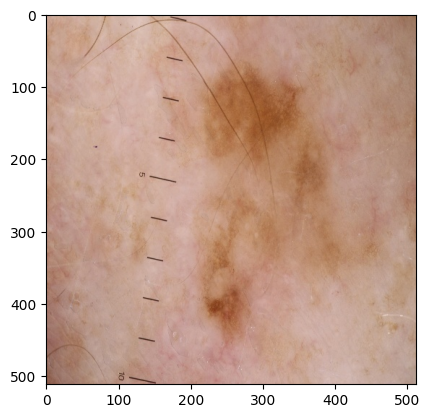

In [ ]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0]

  print("first image to predict")
  plt.imshow(first_image)
  print("first image's actual label:", class_names[first_label])

  batch_prediction = model.predict(images_batch) #mode ready
  #print(batch_prediction[0]) #i want to 1's image
  print(class_names[np.argmax(batch_prediction[0])]) #np.armax actual class,

In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0) #create a batch

  predictions = model.predict(img_array) #call predict funtion

  predicted_class = class_names[np.argmax(predictions[0])] #figureout predicted clz
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence #found the confidence

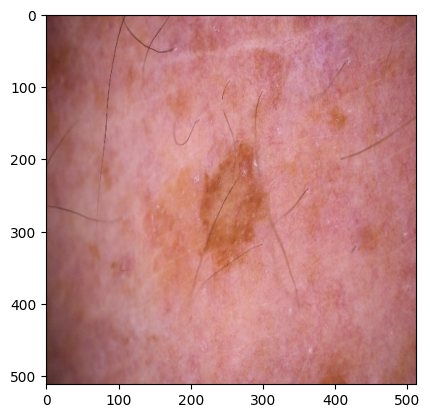

In [ ]:
for images, labels in test_ds.take(1):
  for i in range(9):
    plt.imshow(images[i].numpy().astype("uint8"))

1/1 [==============================] - 0s 19ms/step


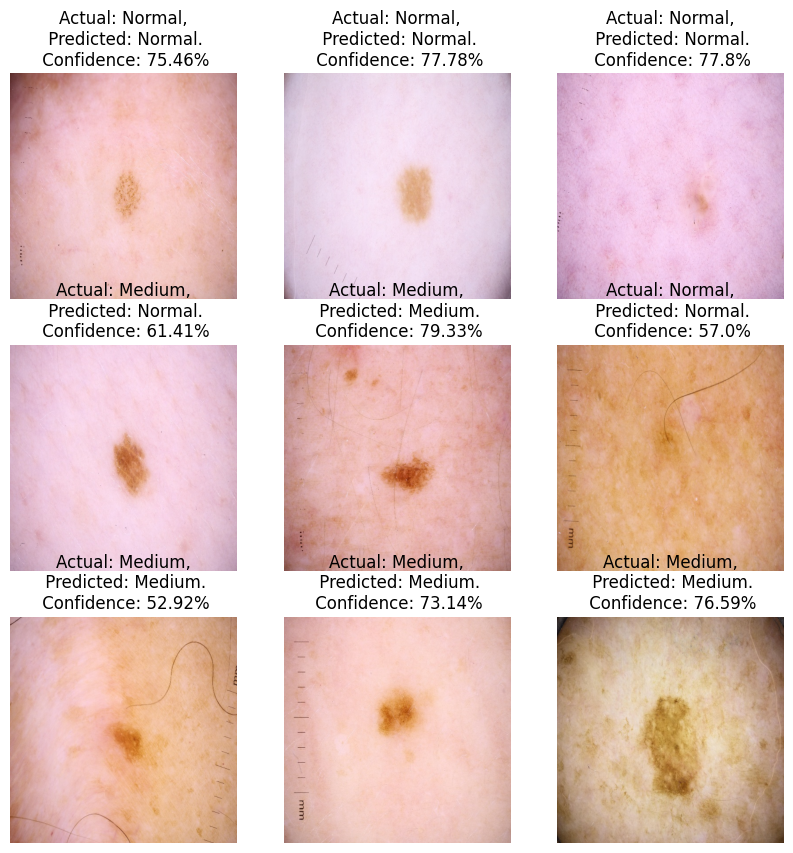

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

    plt.axis("off")

In [ ]:
from tensorflow.keras.models import load_model

model.save('/content/gdrive/MyDrive/Models/disease02.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
